SAME LEXICAL FEATURES ONLY WHOIS WILL ADD

In [1]:
import whois
import dns.resolver
import pandas as pd
from datetime import datetime
from urllib.parse import urlparse
from concurrent.futures import ThreadPoolExecutor, as_completed
import os, time

In [1]:
import whois
import dns.resolver
import pandas as pd
from datetime import datetime
from urllib.parse import urlparse
from concurrent.futures import ThreadPoolExecutor, as_completed
import os, time

# ================================
# 📂 File Paths
# ================================
BASE_FILE = r"D:\QRMODELTRAINING\CSVFILES\QrusaderFeatures.csv"
CACHE_FILE = r"D:\QRMODELTRAINING\CSVFILES\whois_cache.csv"
OUTPUT_FILE = r"D:\QRMODELTRAINING\CSVFILES\QrusaderFeaturesWhois.csv"

# ================================
# 🔎 WHOIS Feature Extractor
# ================================
def get_whois_features(url, retries=3, delay=2):
    domain = urlparse(url).netloc
    features = {
        "URL": url,
        "domain_age_days": 0,
        "domain_age_missing": 1,
        "dns_record": 0,
        "registrar_known": 0,
        "expiration_days": 0,
        "registration_length": 0,
        "whois_privacy": 0,
        "ns_count": 0
    }

    # Check DNS
    try:
        dns.resolver.resolve(domain, 'A')
        features["dns_record"] = 1
    except:
        pass

    for attempt in range(retries):
        try:
            w = whois.whois(domain)
            features["registrar_known"] = 1 if w.registrar else 0
            features["domain_age_missing"] = 0

            # Creation date
            if w.creation_date:
                creation_date = w.creation_date[0] if isinstance(w.creation_date, list) else w.creation_date
                if creation_date:
                    features["domain_age_days"] = (datetime.now() - creation_date).days

            # Expiration date
            if w.expiration_date:
                exp_date = w.expiration_date[0] if isinstance(w.expiration_date, list) else w.expiration_date
                if exp_date:
                    features["expiration_days"] = (exp_date - datetime.now()).days

            # Registration length
            if w.creation_date and w.expiration_date:
                c_date = w.creation_date[0] if isinstance(w.creation_date, list) else w.creation_date
                e_date = w.expiration_date[0] if isinstance(w.expiration_date, list) else w.expiration_date
                if c_date and e_date:
                    features["registration_length"] = (e_date - c_date).days

            # Whois privacy (check org/email)
            if w.org and "privacy" in str(w.org).lower():
                features["whois_privacy"] = 1
            if w.emails and any("privacy" in str(e).lower() for e in (w.emails if isinstance(w.emails, list) else [w.emails])):
                features["whois_privacy"] = 1

            # Nameserver count
            if w.name_servers:
                features["ns_count"] = len(w.name_servers) if isinstance(w.name_servers, list) else 1

            break  # success
        except:
            if attempt < retries - 1:
                time.sleep(delay)

    return features

# ================================
# 1️⃣ Load Base Dataset
# ================================
df = pd.read_csv(BASE_FILE)

# ================================
# 2️⃣ Load WHOIS Cache
# ================================
if os.path.exists(CACHE_FILE):
    cache_df = pd.read_csv(CACHE_FILE)
else:
    cache_df = pd.DataFrame(columns=[
        "URL","domain_age_days","domain_age_missing","dns_record",
        "registrar_known","expiration_days","registration_length",
        "whois_privacy","ns_count"
    ])

processed_urls = set(cache_df["URL"])
urls_to_process = [u for u in df["URL"] if u not in processed_urls]

print(f"✅ Already cached: {len(processed_urls)} | To process: {len(urls_to_process)}")

# ================================
# 3️⃣ Extract WHOIS in Parallel
# ================================
batch_results = []
if urls_to_process:
    with ThreadPoolExecutor(max_workers=15) as executor:
        futures = {executor.submit(get_whois_features, url): url for url in urls_to_process}
        for i, future in enumerate(as_completed(futures), 1):
            result = future.result()
            batch_results.append(result)

            if i % 100 == 0 or i == len(urls_to_process):
                new_df = pd.DataFrame(batch_results)
                cache_df = pd.concat([cache_df, new_df], ignore_index=True).drop_duplicates(subset=["URL"])
                cache_df.to_csv(CACHE_FILE, index=False)
                print(f"💾 Progress saved: {len(cache_df)} cached")
                batch_results = []

# ================================
# 4️⃣ Merge WHOIS into Base Dataset
# ================================
df = df.drop(columns=[
    "domain_age_days","domain_age_missing","dns_record",
    "registrar_known","expiration_days","registration_length",
    "whois_privacy","ns_count"
], errors="ignore")

df = df.merge(cache_df, on="URL", how="left")

# ================================
# 5️⃣ Reorder Columns
# ================================
numerical_cols = [
    'url_length','subdomain_count','path_depth','digit_letter_ratio',
    'special_char_ratio','repeated_char_count','domain_entropy','path_entropy',
    'long_subdomain_length','query_param_count','vowel_count','consonant_count',
    'digit_special_ratio','max_path_segment_length',
    'domain_age_days','expiration_days','registration_length','ns_count'
]

binary_cols = [
    'has_ip','https_token','url_has_suspicious_keywords',
    'has_multiple_subdomains','domain_age_missing','dns_record',
    'registrar_known','whois_privacy'
]

target_cols = ['Label', 'length_cat']

ordered_cols = ['URL', 'URL_normalized'] + numerical_cols + binary_cols + target_cols
df = df.reindex(columns=ordered_cols)

# ================================
# 6️⃣ Save Final Dataset
# ================================
df.to_csv(OUTPUT_FILE, index=False)
print(f"🎯 Final dataset saved: {OUTPUT_FILE}")


✅ Already cached: 6600 | To process: 13398


2025-09-24 10:06:21,556 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 10:06:35,830 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 6700 cached


2025-09-24 10:06:46,090 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:06:50,142 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it
2025-09-24 10:06:51,063 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:06:52,798 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:06:53,842 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:06:55,505 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:07:00,129 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be mad

💾 Progress saved: 6800 cached


2025-09-24 10:07:04,216 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it


💾 Progress saved: 6900 cached


2025-09-24 10:07:27,497 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 7000 cached


2025-09-24 10:07:50,665 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:07:51,714 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it


💾 Progress saved: 7100 cached


2025-09-24 10:09:04,328 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:09:11,334 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:09:12,432 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 10:09:16,920 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 7200 cached


2025-09-24 10:09:18,518 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:09:26,004 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:09:32,692 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:09:34,894 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 7300 cached


2025-09-24 10:09:38,405 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it
2025-09-24 10:09:50,711 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 7400 cached


2025-09-24 10:10:05,840 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:10:18,428 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 7500 cached


2025-09-24 10:10:26,255 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:10:31,235 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 7600 cached


2025-09-24 10:10:42,432 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:10:49,597 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:10:57,060 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 7700 cached


2025-09-24 10:11:07,200 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:11:12,988 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:11:13,307 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:11:13,908 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it
2025-09-24 10:11:28,391 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 7800 cached


2025-09-24 10:11:29,091 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:12:22,029 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 7900 cached
💾 Progress saved: 8000 cached


2025-09-24 10:14:23,990 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:14:24,500 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host


💾 Progress saved: 8100 cached


2025-09-24 10:14:32,287 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 8200 cached


2025-09-24 10:16:16,927 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:17:18,370 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 8300 cached


2025-09-24 10:17:28,425 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:17:30,312 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:17:31,745 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:17:34,473 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it
2025-09-24 10:17:34,927 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it
2025-09-24 10:17:35,359 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 8400 cached


2025-09-24 10:19:15,123 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 10:20:24,733 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:20:27,559 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 8500 cached


2025-09-24 10:20:40,367 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 8600 cached


2025-09-24 10:22:25,532 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 8700 cached


2025-09-24 10:22:39,722 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:22:46,516 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 8800 cached


2025-09-24 10:23:12,254 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 8900 cached


2025-09-24 10:23:14,350 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:24:13,095 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 10:24:13,095 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 10:25:46,140 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 9000 cached


2025-09-24 10:26:02,014 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 9100 cached


2025-09-24 10:27:33,966 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:27:33,966 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 10:28:37,618 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 9200 cached
💾 Progress saved: 9300 cached


2025-09-24 10:29:17,117 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 9400 cached


2025-09-24 10:29:26,465 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it
2025-09-24 10:29:30,497 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 9500 cached


2025-09-24 10:31:52,713 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:31:58,894 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:32:01,645 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 9600 cached


2025-09-24 10:32:14,233 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:32:19,114 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:32:19,195 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it


💾 Progress saved: 9700 cached


2025-09-24 10:32:25,146 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:32:35,759 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 9800 cached


2025-09-24 10:32:44,997 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:34:26,701 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:34:37,037 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:34:42,833 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 9900 cached


2025-09-24 10:34:45,972 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:35:51,429 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 10:35:52,300 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host


💾 Progress saved: 10000 cached


2025-09-24 10:36:07,498 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:36:09,110 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:36:24,131 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 10100 cached


2025-09-24 10:36:30,467 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:36:39,069 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 10200 cached
💾 Progress saved: 10300 cached


2025-09-24 10:37:15,042 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 10400 cached


2025-09-24 10:37:34,274 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 10500 cached


2025-09-24 10:39:33,338 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:39:38,704 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:39:40,141 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:39:46,836 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:39:52,032 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 10600 cached


2025-09-24 10:39:56,818 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:39:58,312 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 10700 cached


2025-09-24 10:40:14,863 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:40:20,498 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 10800 cached


2025-09-24 10:41:28,644 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:41:32,061 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 10900 cached


2025-09-24 10:42:54,295 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it
2025-09-24 10:43:01,102 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 11000 cached


2025-09-24 10:43:17,698 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it
2025-09-24 10:43:20,987 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:43:32,855 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:43:33,986 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 11100 cached


2025-09-24 10:43:53,707 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 11200 cached


2025-09-24 10:44:08,032 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:44:10,980 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:44:11,902 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it


💾 Progress saved: 11300 cached


2025-09-24 10:44:27,331 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:44:29,715 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:44:32,496 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it


💾 Progress saved: 11400 cached
💾 Progress saved: 11500 cached


2025-09-24 10:44:59,406 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:45:05,219 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 11600 cached


2025-09-24 10:45:20,060 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:46:09,335 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 11700 cached


2025-09-24 10:46:24,366 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 11800 cached


2025-09-24 10:46:29,960 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:46:33,492 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:50:31,130 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:50:31,131 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:50:31,131 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:50:31,815 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 10:51:26,934 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10053] An established connection was aborted by the software in your host machine
2025-09-24 10:51:26,937 - whois.whois - ERROR - Error tr

💾 Progress saved: 11900 cached


2025-09-24 10:52:06,207 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:52:15,432 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it
2025-09-24 10:52:17,612 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:52:20,131 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 12000 cached
💾 Progress saved: 12100 cached


2025-09-24 10:52:45,615 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:52:48,855 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:53:46,566 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 10:53:46,567 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10053] An established connection was aborted by the software in your host machine
2025-09-24 10:54:23,986 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:54:26,470 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 12200 cached


2025-09-24 10:54:35,876 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:54:38,396 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:54:39,636 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:54:43,123 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 12300 cached


2025-09-24 10:54:53,936 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it


💾 Progress saved: 12400 cached


2025-09-24 10:56:37,536 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it
2025-09-24 10:56:38,312 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it
2025-09-24 10:56:38,313 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 10:56:38,320 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 10:56:38,320 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10053] An established connection was aborted by the software in your host machine
2025-09-24 10:57:10,445 - whois.whois - ERROR - Error trying to co

💾 Progress saved: 12500 cached


2025-09-24 10:57:15,073 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:57:15,764 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:57:23,006 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:57:26,534 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:57:30,121 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:57:31,773 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 12600 cached
💾 Progress saved: 12700 cached


2025-09-24 10:58:43,297 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:58:49,367 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 12800 cached


2025-09-24 10:59:00,040 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 10:59:37,261 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 10:59:47,274 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:59:47,890 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:59:47,890 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 10:59:50,193 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 12900 cached


2025-09-24 11:00:03,913 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:00:08,124 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 13000 cached


2025-09-24 11:00:11,701 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:00:16,127 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 13100 cached


2025-09-24 11:00:32,892 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:00:36,272 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:00:39,808 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 13200 cached
💾 Progress saved: 13300 cached


2025-09-24 11:01:12,939 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:01:19,305 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:01:48,418 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:01:49,196 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:01:49,197 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:01:50,014 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:01:51,080 - whois.whois - ERROR - Error trying to connect to socket: clos

💾 Progress saved: 13400 cached


2025-09-24 11:01:55,397 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:01:59,960 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 13500 cached


2025-09-24 11:02:42,622 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:02:51,799 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 13600 cached


2025-09-24 11:03:41,403 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host


💾 Progress saved: 13700 cached


2025-09-24 11:03:46,917 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:04:19,671 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:04:19,676 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host


💾 Progress saved: 13800 cached


2025-09-24 11:05:41,363 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 13900 cached


2025-09-24 11:05:42,885 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:05:45,129 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:05:49,393 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it
2025-09-24 11:05:50,314 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:05:51,564 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:05:52,122 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 14000 cached


2025-09-24 11:06:30,041 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:06:34,519 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 14100 cached


2025-09-24 11:06:42,707 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:06:49,465 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:06:59,162 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:06:59,315 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:07:28,799 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 14200 cached


2025-09-24 11:08:00,336 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:08:00,596 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10053] An established connection was aborted by the software in your host machine


💾 Progress saved: 14300 cached


2025-09-24 11:08:22,234 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it


💾 Progress saved: 14400 cached


2025-09-24 11:09:03,492 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:09:03,496 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:09:03,496 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:09:18,651 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:09:46,636 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:09:46,641 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:09:46,643 - whois.whois - ERROR - Error trying to 

💾 Progress saved: 14500 cached


2025-09-24 11:10:02,524 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 14600 cached


2025-09-24 11:10:07,956 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:10:07,970 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:10:21,719 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 14700 cached


2025-09-24 11:10:24,225 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:10:26,088 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it
2025-09-24 11:10:34,715 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:10:42,188 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 14800 cached


2025-09-24 11:11:13,061 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:11:14,953 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:11:19,101 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:11:23,314 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 14900 cached


2025-09-24 11:11:35,846 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:11:41,773 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:11:44,234 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 15000 cached


2025-09-24 11:11:46,036 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:12:13,701 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 15100 cached


2025-09-24 11:12:16,971 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 15200 cached


2025-09-24 11:13:04,072 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:13:12,715 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 15300 cached


2025-09-24 11:13:42,914 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10053] An established connection was aborted by the software in your host machine
2025-09-24 11:13:44,509 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:13:47,797 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:14:16,996 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:14:17,000 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host


💾 Progress saved: 15400 cached


2025-09-24 11:14:28,514 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:14:28,684 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:14:30,658 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:15:00,698 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host


💾 Progress saved: 15500 cached


2025-09-24 11:15:12,590 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:15:13,433 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:15:18,898 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:15:30,008 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 15600 cached


2025-09-24 11:15:51,634 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 15700 cached


2025-09-24 11:15:56,040 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:15:56,962 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:16:04,919 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:16:13,833 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 15800 cached


2025-09-24 11:16:55,214 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 15900 cached


2025-09-24 11:17:02,493 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:17:12,105 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:17:13,597 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:17:14,693 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:17:15,542 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:17:20,200 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 16000 cached


2025-09-24 11:17:23,370 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:17:36,056 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 16100 cached


2025-09-24 11:17:42,245 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:17:43,696 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:17:46,261 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:17:58,744 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:18:02,560 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 16200 cached


2025-09-24 11:18:24,581 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 16300 cached


2025-09-24 11:18:34,797 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:18:41,824 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:18:44,061 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it
2025-09-24 11:18:49,431 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it


💾 Progress saved: 16400 cached


2025-09-24 11:18:55,121 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:18:55,226 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:18:55,551 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 16500 cached


2025-09-24 11:19:20,325 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:19:22,224 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:19:25,759 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 16600 cached


2025-09-24 11:19:57,295 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:20:05,880 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 16700 cached


2025-09-24 11:20:18,161 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:20:55,407 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:20:55,412 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 16800 cached


2025-09-24 11:21:04,820 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 16900 cached


2025-09-24 11:21:19,570 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:22:07,087 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host


💾 Progress saved: 17000 cached


2025-09-24 11:23:32,558 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:23:38,726 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 17100 cached


2025-09-24 11:23:49,016 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:24:00,591 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 17200 cached


2025-09-24 11:24:02,562 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:24:07,505 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:24:13,558 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:24:19,959 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 17300 cached


2025-09-24 11:24:31,593 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:24:59,983 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 17400 cached


2025-09-24 11:25:08,784 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:25:13,371 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 17500 cached


2025-09-24 11:25:53,764 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:25:53,765 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:25:54,287 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:26:26,605 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:26:27,563 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host


💾 Progress saved: 17600 cached


2025-09-24 11:26:42,318 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:26:52,441 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:26:54,409 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 17700 cached


2025-09-24 11:27:01,620 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:27:10,268 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 17800 cached


2025-09-24 11:27:35,236 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:27:36,691 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 17900 cached
💾 Progress saved: 18000 cached


2025-09-24 11:28:36,147 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:28:36,148 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host


💾 Progress saved: 18100 cached


2025-09-24 11:29:23,601 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 18200 cached


2025-09-24 11:29:31,951 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10061] No connection could be made because the target machine actively refused it
2025-09-24 11:29:53,242 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:29:53,293 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:29:53,390 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:29:54,537 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 18300 cached


2025-09-24 11:30:14,217 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:30:41,767 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:30:46,821 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:30:47,695 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:30:49,895 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 18400 cached


2025-09-24 11:30:59,051 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:30:59,439 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:31:08,820 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:31:35,820 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:31:41,212 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 18500 cached


2025-09-24 11:32:02,600 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 18600 cached


2025-09-24 11:32:09,243 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:32:12,025 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11002] getaddrinfo failed
2025-09-24 11:32:13,454 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 18700 cached


2025-09-24 11:32:27,615 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:32:33,866 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 18800 cached


2025-09-24 11:33:57,737 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10053] An established connection was aborted by the software in your host machine


💾 Progress saved: 18900 cached


2025-09-24 11:34:36,664 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:34:36,664 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:34:37,207 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:34:40,298 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:34:47,493 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 19000 cached


2025-09-24 11:34:50,661 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:34:53,743 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:34:56,797 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host


💾 Progress saved: 19100 cached


2025-09-24 11:35:13,099 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:35:18,899 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:35:27,691 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 19200 cached


2025-09-24 11:35:31,106 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out


💾 Progress saved: 19300 cached


2025-09-24 11:35:55,534 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:36:04,740 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 19400 cached


2025-09-24 11:36:10,125 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:36:17,374 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 19500 cached


2025-09-24 11:36:40,214 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:36:43,655 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 19600 cached


2025-09-24 11:36:55,522 - whois.whois - ERROR - Error trying to connect to socket: closing socket - timed out
2025-09-24 11:37:01,677 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:37:01,692 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 19700 cached


2025-09-24 11:37:29,119 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [WinError 10054] An existing connection was forcibly closed by the remote host
2025-09-24 11:37:30,257 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 19800 cached
💾 Progress saved: 19900 cached


2025-09-24 11:38:19,636 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed
2025-09-24 11:38:30,378 - whois.whois - ERROR - Error trying to connect to socket: closing socket - [Errno 11001] getaddrinfo failed


💾 Progress saved: 19998 cached
🎯 Final dataset saved: D:\QRMODELTRAINING\CSVFILES\QrusaderFeaturesWhois.csv


FEATURE ANALYSIS OF WHOIS ONLY

In [2]:
numeric_features = [
     'domain_age_days', 'expiration_days', 'registration_length', 'ns_count'
]

# Updated binary features
binary_features = [
     'domain_age_missing', 'dns_record', 'registrar_known', 'whois_privacy'
]

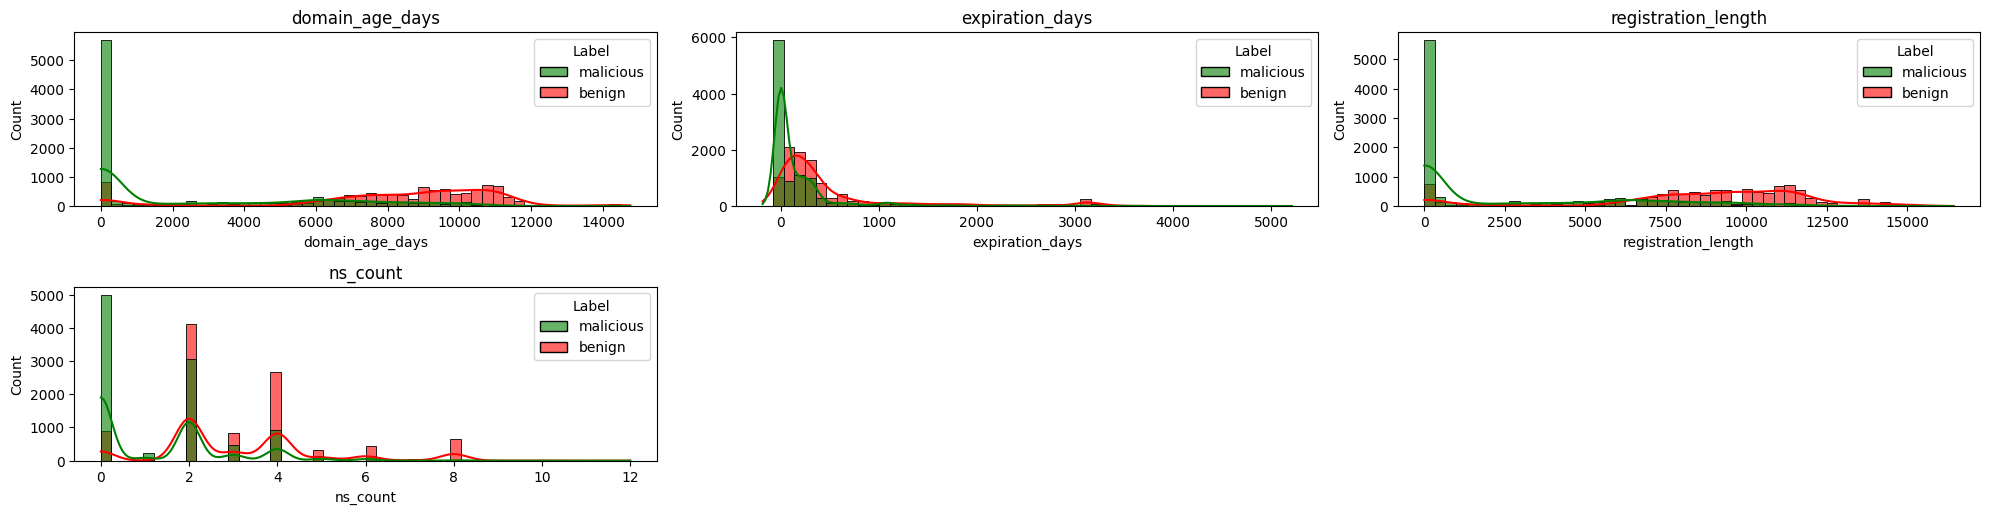

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ===============================
# Plot numeric features
# ===============================
# ===============================
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features):
    plt.subplot(6, 3, i+1)  # 6 rows x 3 cols grid is fine for 17 features
    if df[feature].nunique() > 1:
        sns.histplot(data=df, x=feature, hue='Label', bins=50, kde=True, palette=['green','red'], alpha=0.6)
    else:
        sns.histplot(data=df, x=feature, hue='Label', bins=50, palette=['green','red'])
    plt.title(feature)
plt.tight_layout()
plt.show()

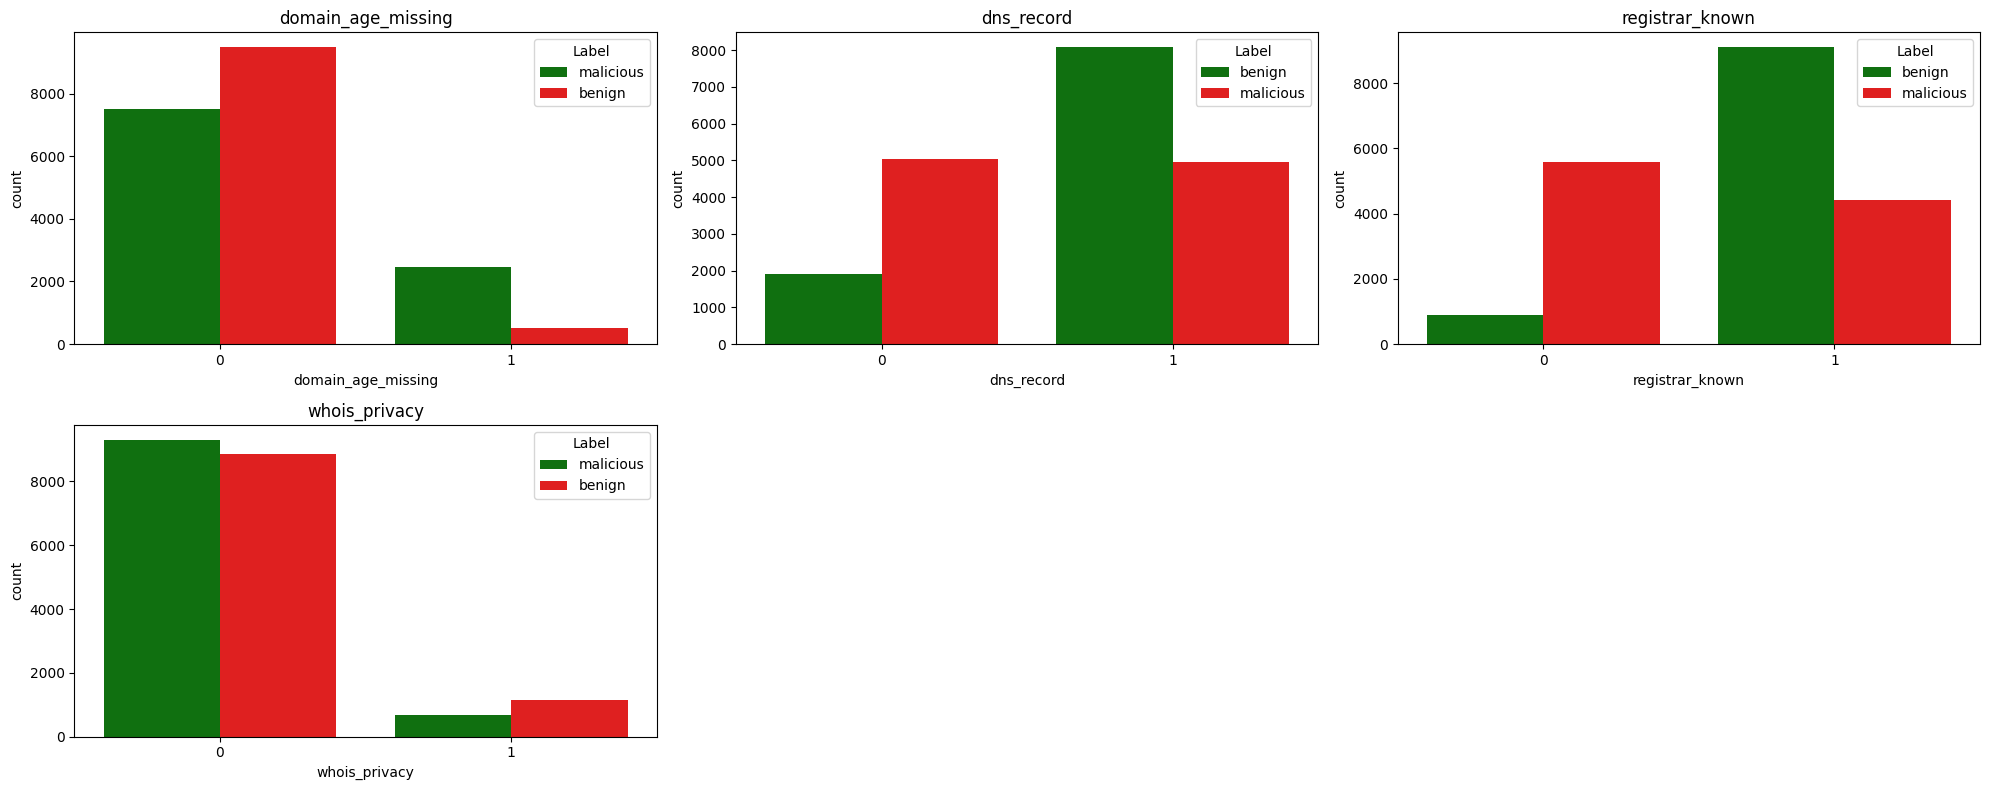

In [4]:
# ===============================
# Plot binary features
# ===============================
plt.figure(figsize=(20, 8))
for i, feature in enumerate(binary_features):
    plt.subplot(2, 3, i+1)  # adjust grid for 6 features
    sns.countplot(x=feature, hue='Label', data=df, palette=['green','red'])
    plt.title(feature)
plt.tight_layout()
plt.show()

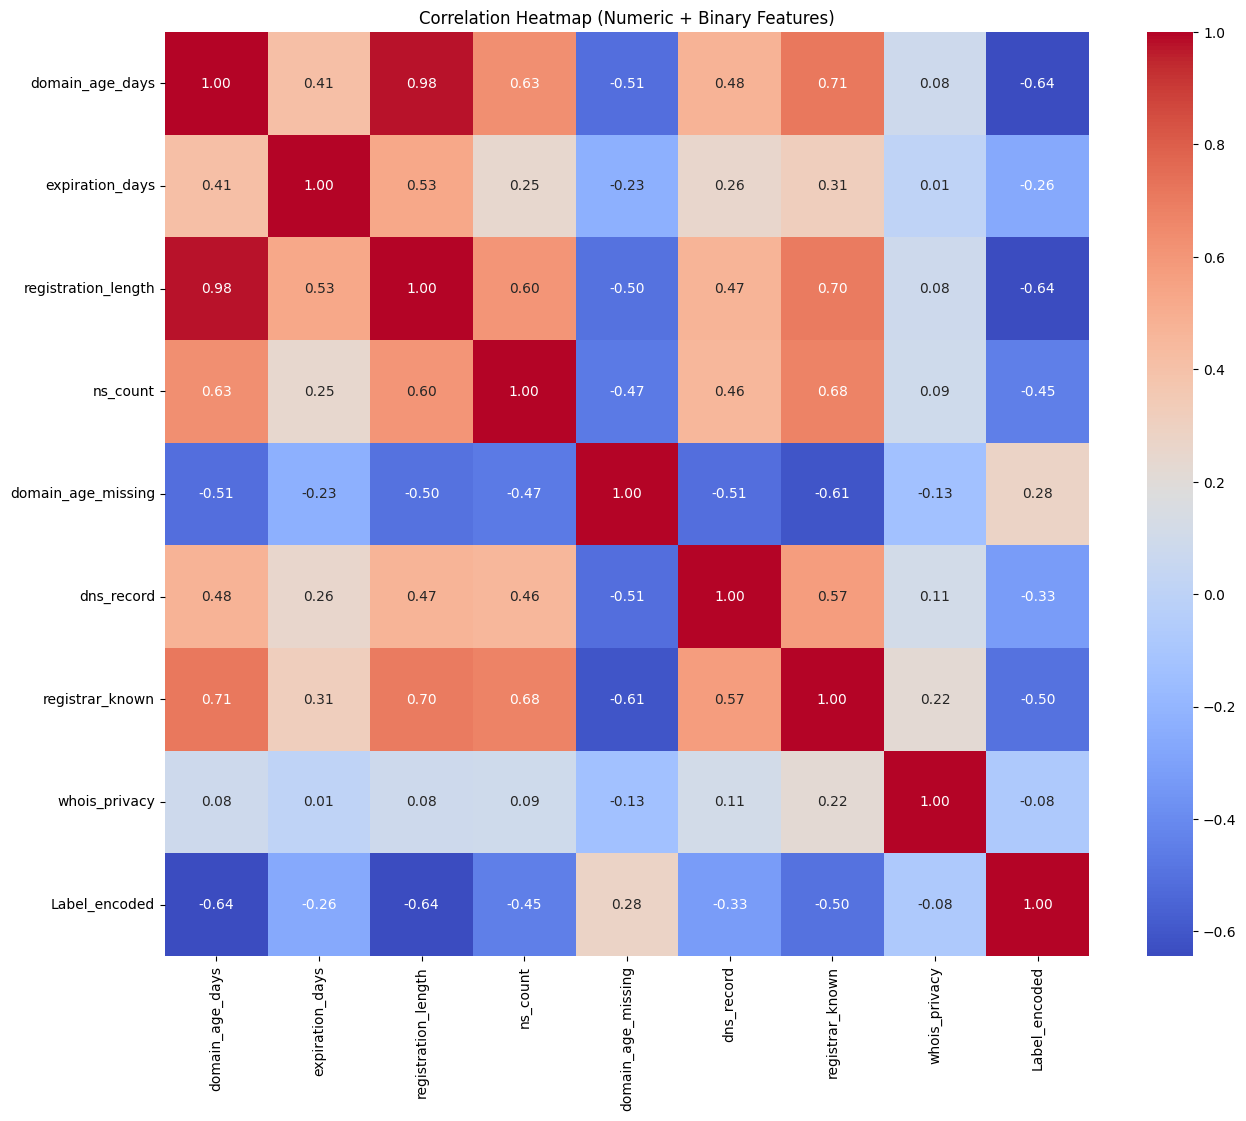

In [5]:
# ===============================
# Correlation heatmap
# ===============================
# Encode labels
df['Label_encoded'] = df['Label'].map({'benign': 0, 'malicious': 1})
plt.figure(figsize=(15, 12))
corr_matrix = df[numeric_features + binary_features + ['Label_encoded']].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap (Numeric + Binary Features)")
plt.show()

FULL FEATURE ANALYSIS (LEXICAL AND WHOIS)

In [6]:
numeric_features = [
    'url_length', 'subdomain_count', 'path_depth', 'digit_letter_ratio',
    'special_char_ratio', 'repeated_char_count', 'domain_entropy',
    'path_entropy', 'long_subdomain_length', 'query_param_count',
    'vowel_count', 'consonant_count', 'digit_special_ratio',
    'max_path_segment_length', 'domain_age_days', 'expiration_days', 'registration_length', 'ns_count'
]

# Updated binary features
binary_features = [
    'has_ip', 'https_token', 'url_has_suspicious_keywords', 'has_multiple_subdomains', 'domain_age_missing', 'dns_record', 'registrar_known', 'whois_privacy'
]



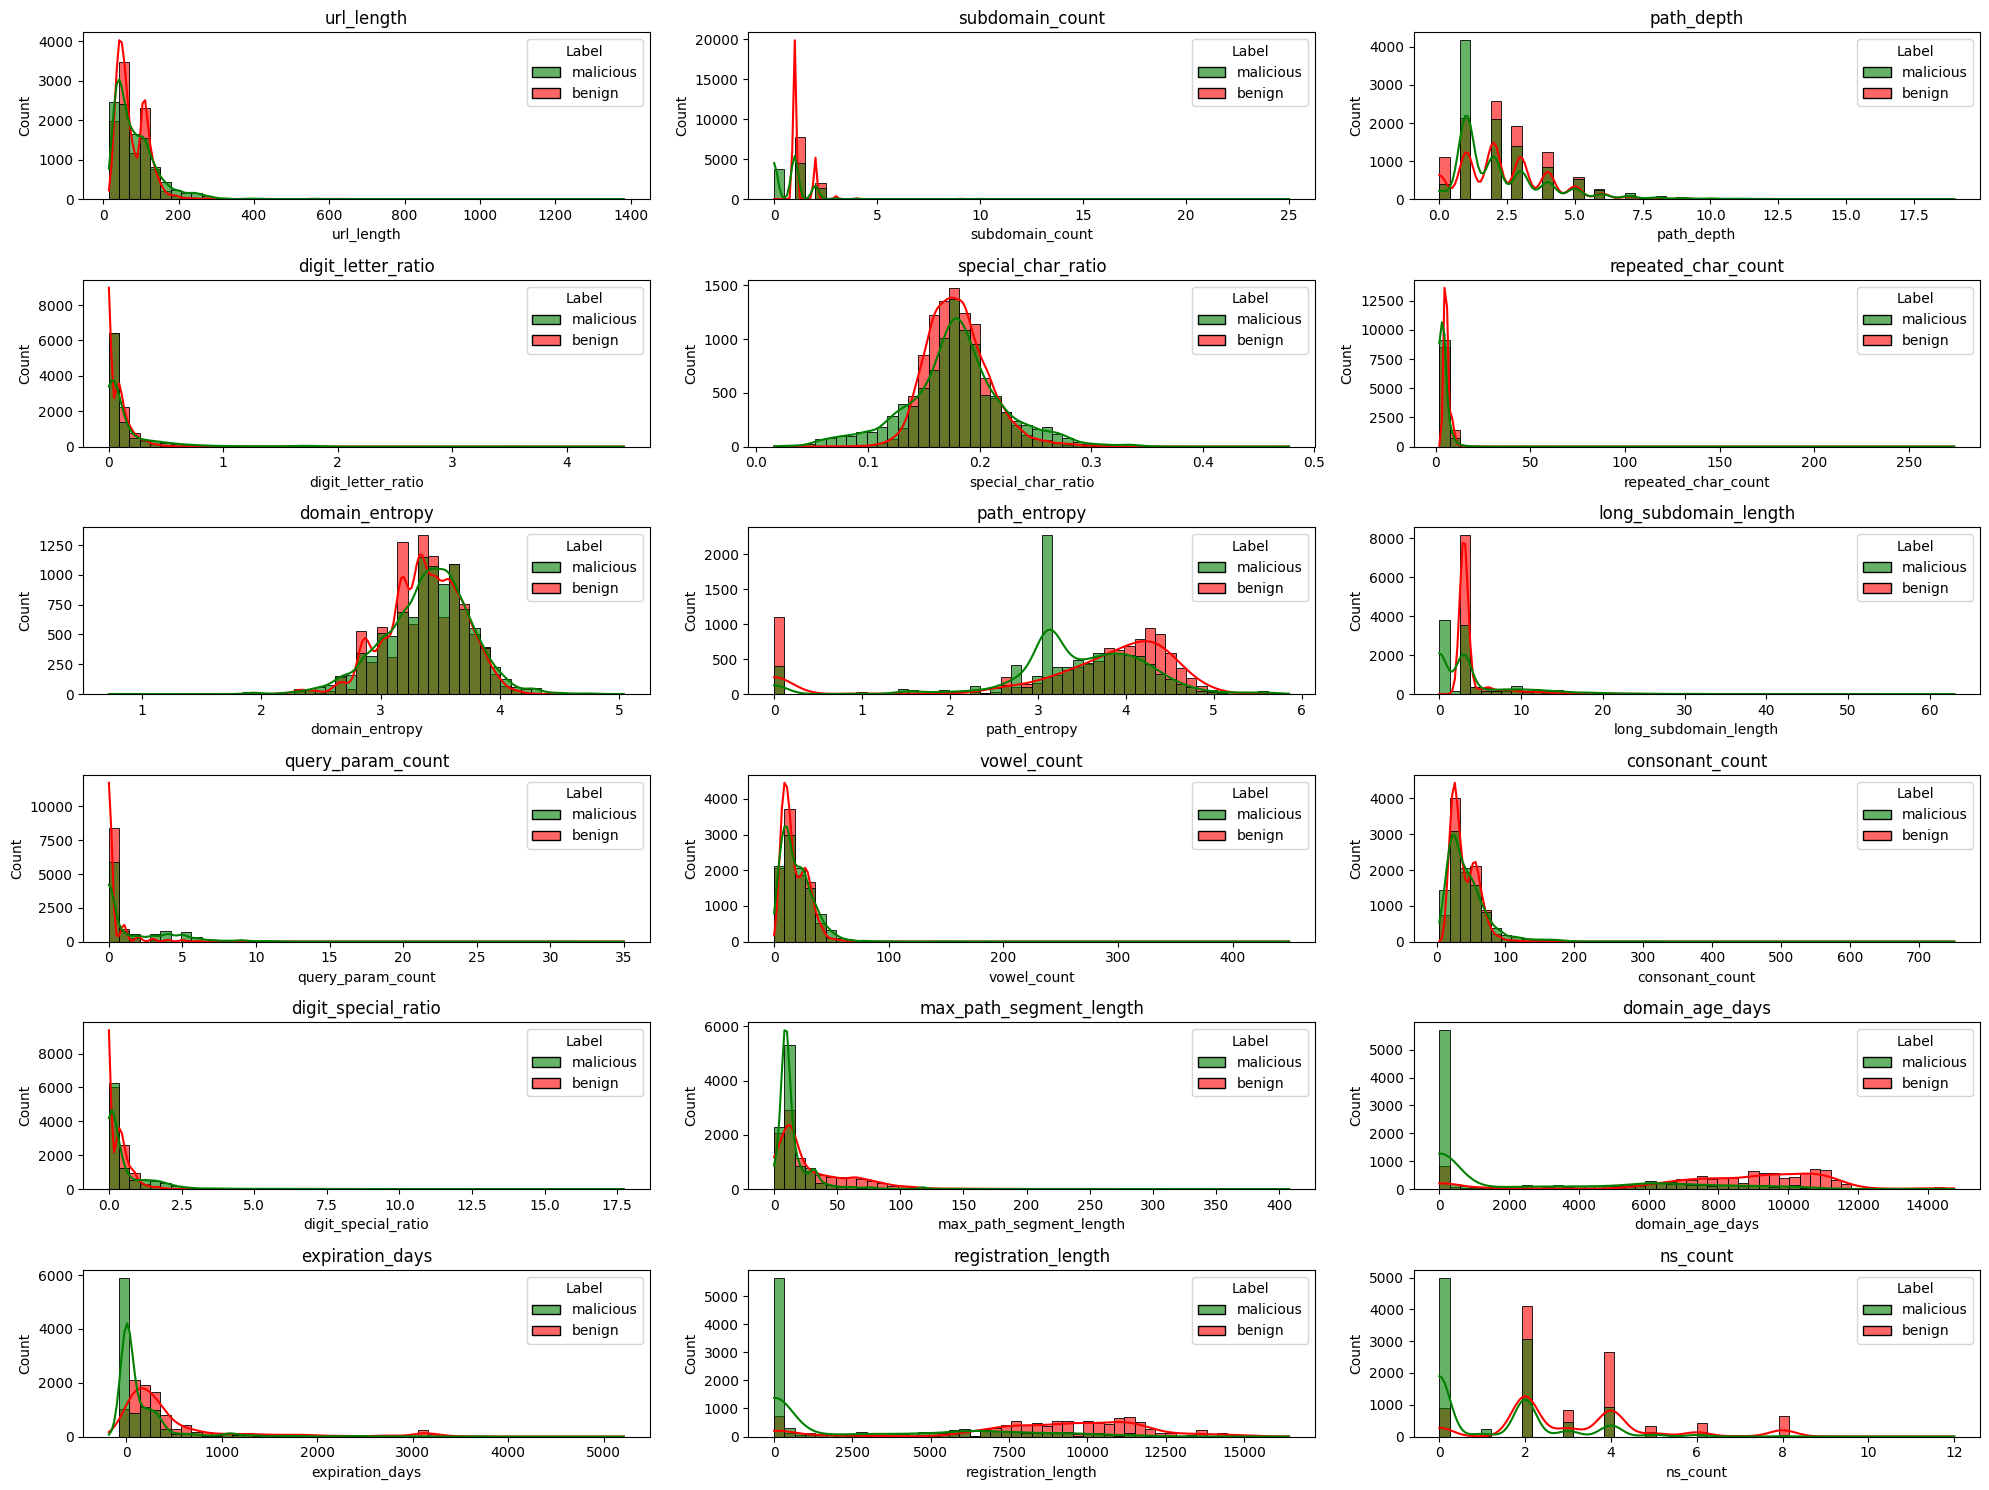

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ===============================
# Plot numeric features
# ===============================
# ===============================
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features):
    plt.subplot(6, 3, i+1)  # 6 rows x 3 cols grid is fine for 17 features
    if df[feature].nunique() > 1:
        sns.histplot(data=df, x=feature, hue='Label', bins=50, kde=True, palette=['green','red'], alpha=0.6)
    else:
        sns.histplot(data=df, x=feature, hue='Label', bins=50, palette=['green','red'])
    plt.title(feature)
plt.tight_layout()
plt.show()

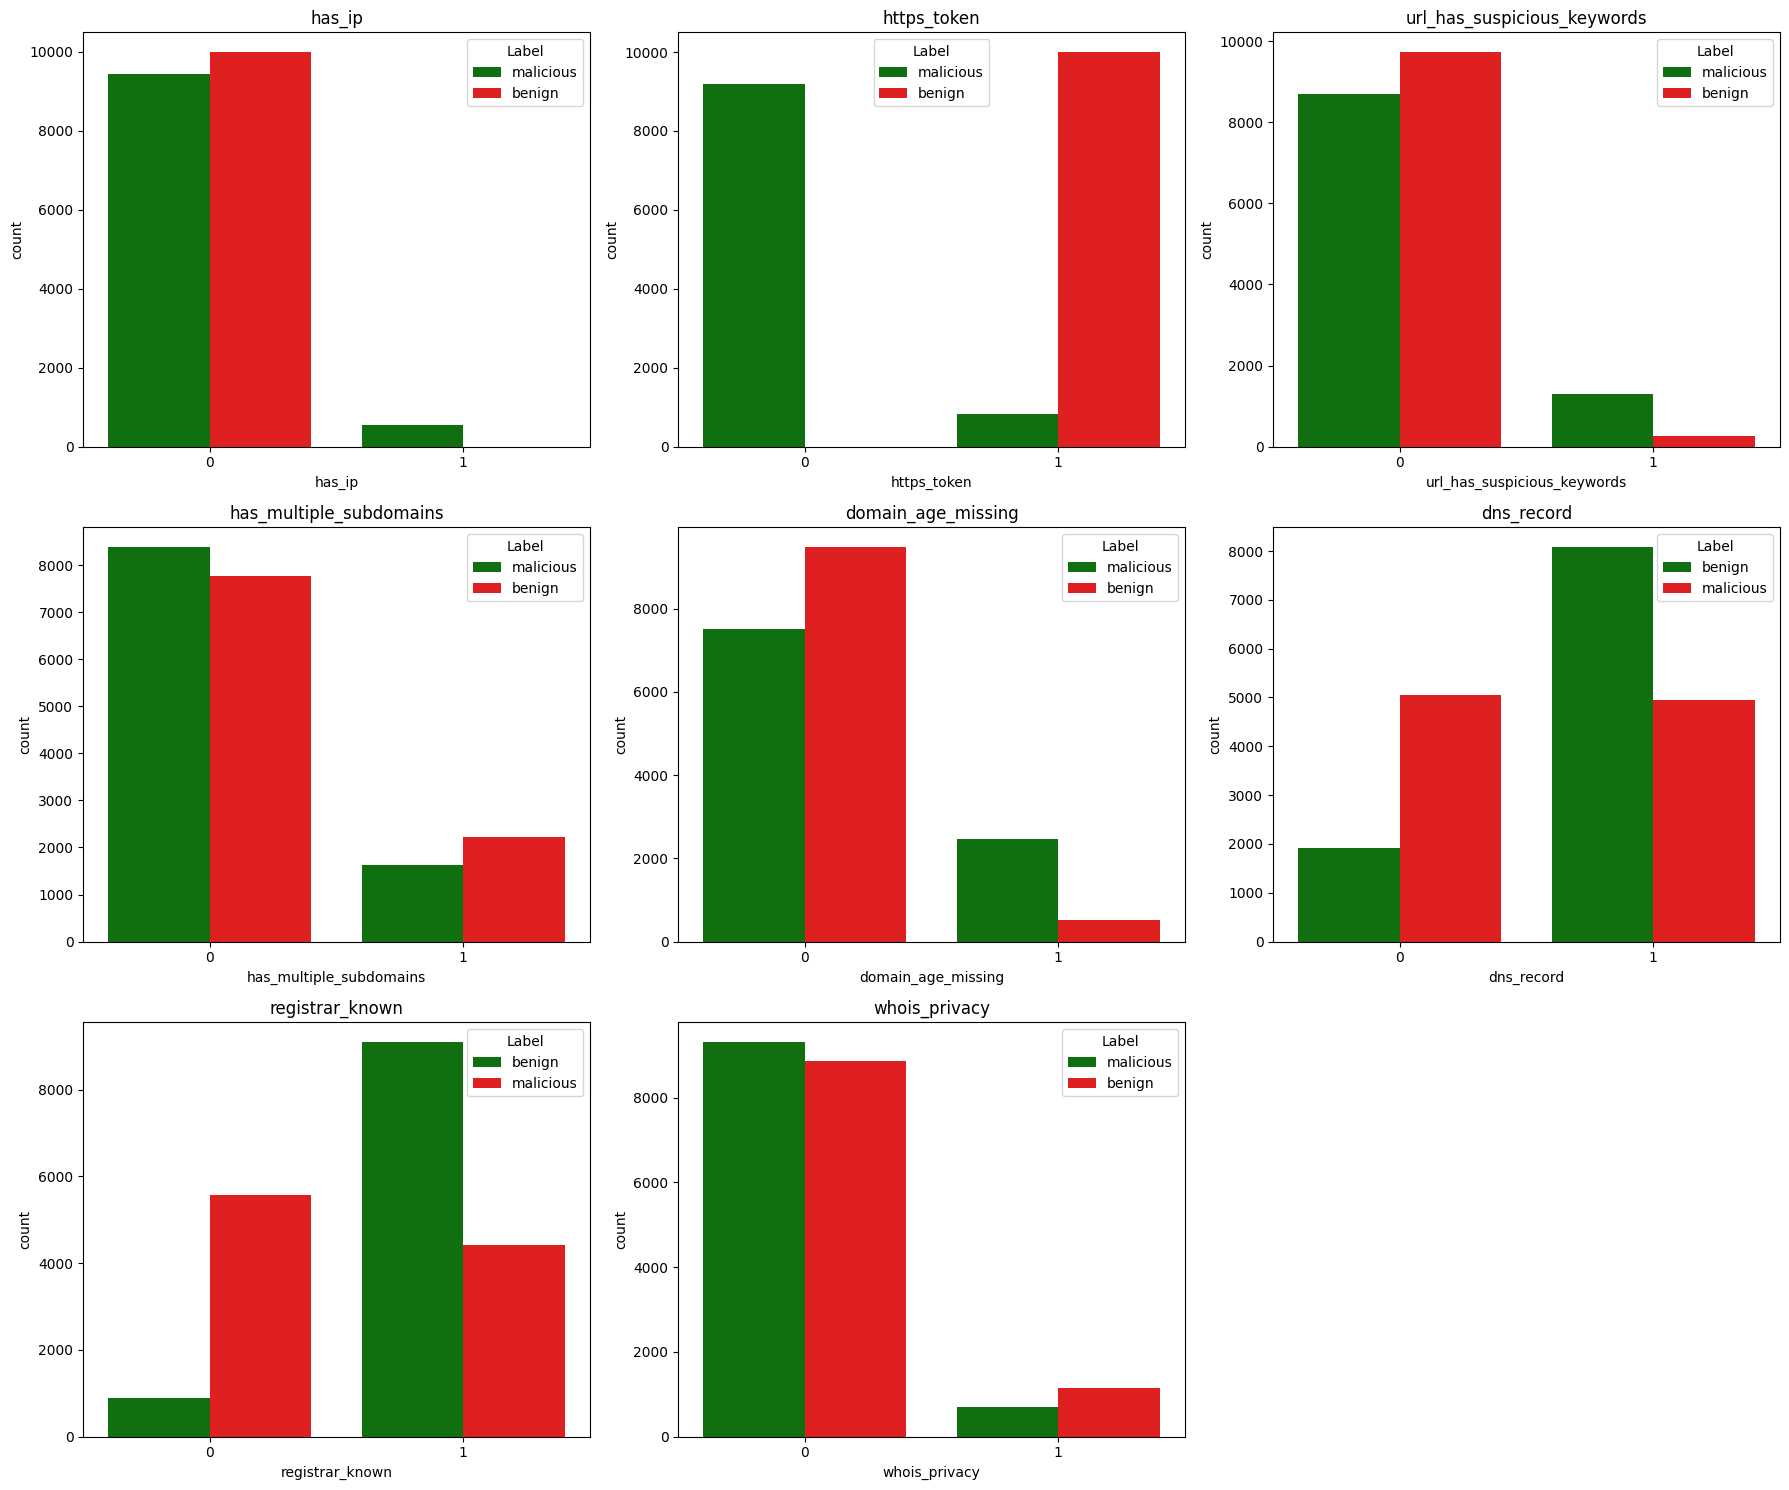

In [14]:
# ===============================
# Plot binary features
# ===============================
n_features = len(binary_features)
n_cols = 3  # how many plots per row
n_rows = (n_features + n_cols - 1) // n_cols  # auto calculate needed rows

plt.figure(figsize=(6 * n_cols, 5 * n_rows))
for i, feature in enumerate(binary_features):
    plt.subplot(n_rows, n_cols, i+1)
    sns.countplot(x=feature, hue='Label', data=df, palette=['green','red'])
    plt.title(feature)
plt.tight_layout()
plt.show()


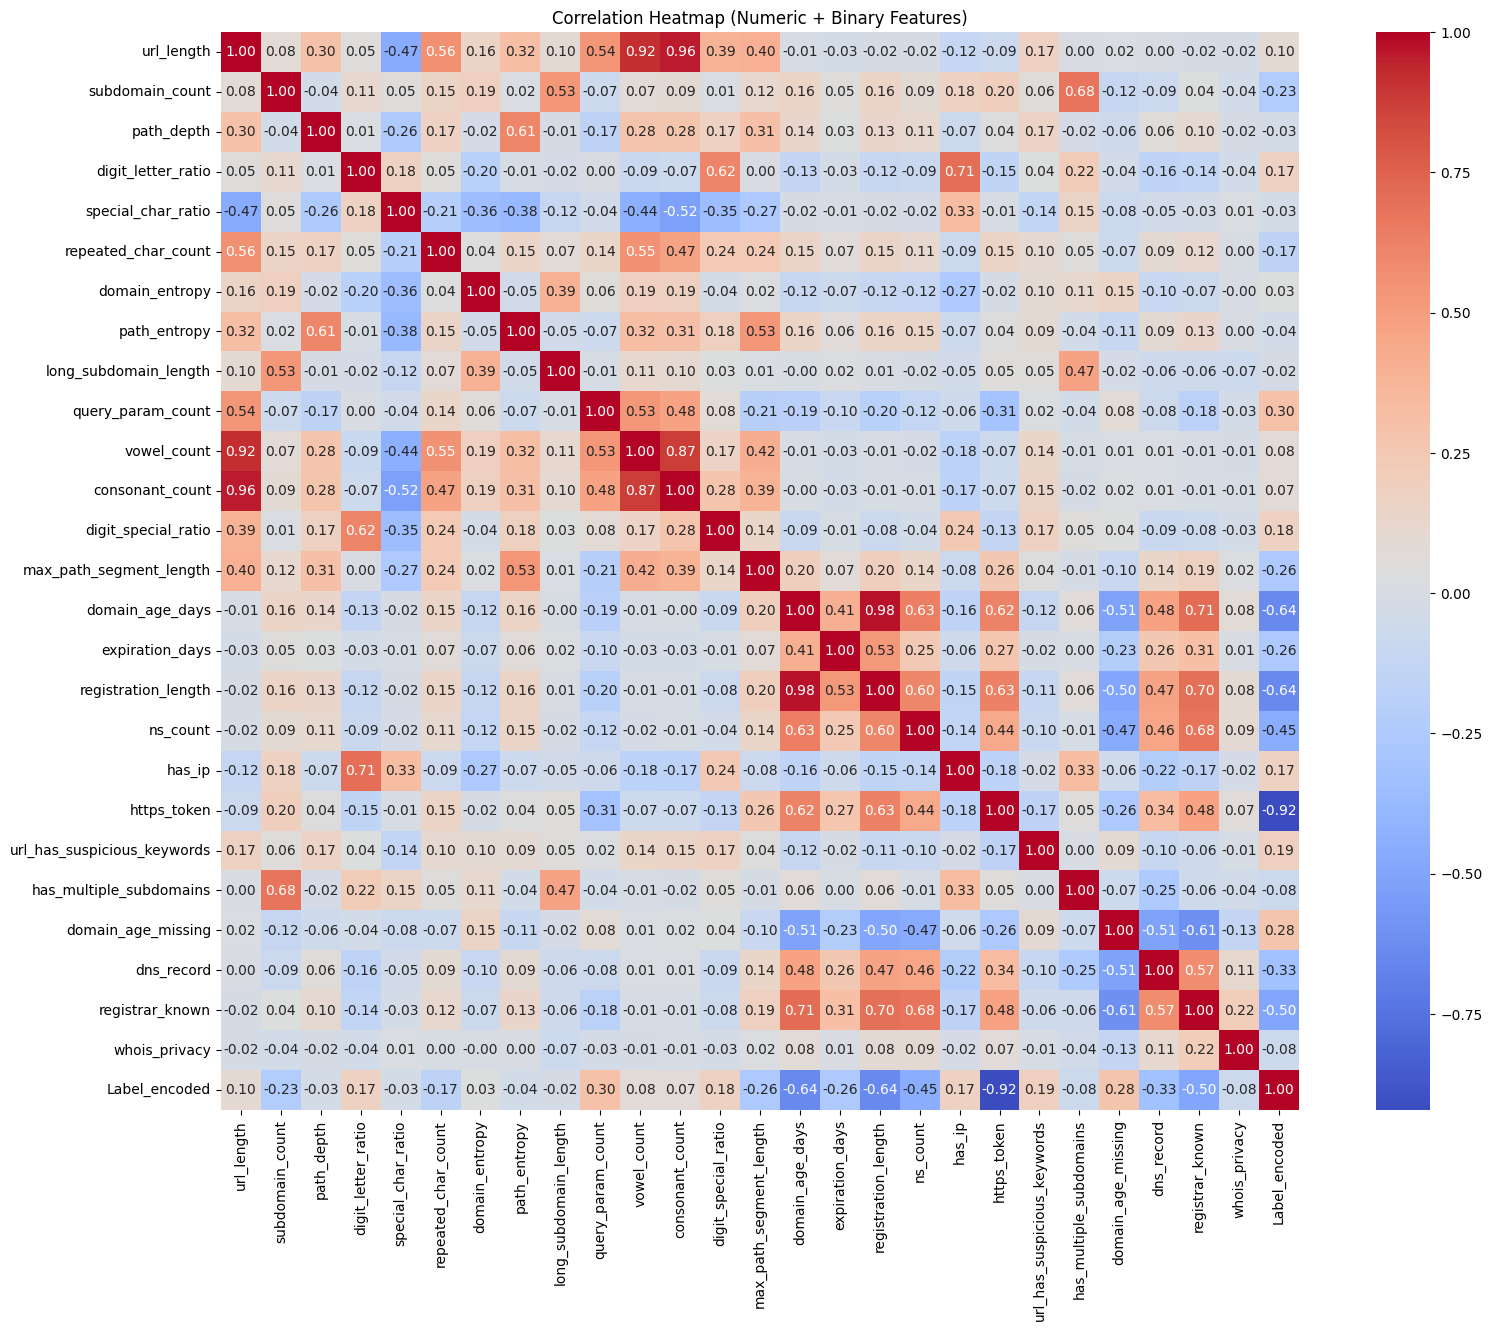

In [16]:
# ===============================
# Correlation heatmap
# ===============================
# Encode labels
df['Label_encoded'] = df['Label'].map({'benign': 0, 'malicious': 1})
plt.figure(figsize=(20, 14))
corr_matrix = df[numeric_features + binary_features + ['Label_encoded']].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap (Numeric + Binary Features)")
plt.show()

CHECK WHICH FEATURES WITH WHOIS ARE STRONG AND WEAK

In [17]:
# ===============================
# 1️⃣ Summary statistics for numeric features
# ===============================
print("=== Numeric Feature Summary ===")
for feature in numeric_features:
    print(f"\nFeature: {feature}")
    print(df.groupby('Label')[feature].describe())

# ===============================
# 2️⃣ Counts for binary features
# ===============================
print("\n=== Binary Feature Counts ===")
for feature in binary_features:
    print(f"\nFeature: {feature}")
    print(pd.crosstab(df[feature], df['Label']))

# ===============================
# 3️⃣ Correlation with Label_encoded
# ===============================
# Encode labels
df['Label_encoded'] = df['Label'].map({'benign': 0, 'malicious': 1})

corr_matrix = df[numeric_features + binary_features + ['Label_encoded']].corr()
print("\n=== Correlation with Label_encoded ===")
for feature in numeric_features + binary_features:
    corr = corr_matrix.loc[feature, 'Label_encoded']
    print(f"{feature}: {corr:.3f}")

# ===============================
# 4️⃣ Optional: rank features by absolute correlation
# ===============================
feature_corr_rank = corr_matrix['Label_encoded'].drop('Label_encoded').abs().sort_values(ascending=False)
print("\n=== Features ranked by absolute correlation with Label ===")
print(feature_corr_rank)


=== Numeric Feature Summary ===

Feature: url_length
            count       mean        std   min   25%   50%    75%     max
Label                                                                   
benign     9999.0  76.781178  40.456659  18.0  45.0  64.0  107.0   651.0
malicious  9999.0  87.667367  67.023863  15.0  43.0  72.0  112.0  1382.0

Feature: subdomain_count
            count      mean       std  min  25%  50%  75%   max
Label                                                          
benign     9999.0  1.244724  0.491186  0.0  1.0  1.0  1.0   5.0
malicious  9999.0  0.850285  1.065136  0.0  0.0  1.0  1.0  25.0

Feature: path_depth
            count      mean       std  min  25%  50%  75%   max
Label                                                          
benign     9999.0  2.388839  1.657821  0.0  1.0  2.0  3.0  15.0
malicious  9999.0  2.273127  1.805425  0.0  1.0  2.0  3.0  19.0

Feature: digit_letter_ratio
            count      mean       std  min  25%       50%   75%    